In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from numba import cfunc, jit
from numba.types import float64
import numpy as np
import os
from scipy import LowLevelCallable
from scipy.integrate import quad, dblquad, nquad

from background_models import bg_dampe
from constants import dampe_excess_bin_high as mx
from constants import e_low_aniso_fermi, e_high_aniso_fermi, dampe_excess_bin_high
from constants import fermi_psf, kpc_to_cm, dampe_excess_bin_low, dampe_excess_iflux
from finite_clump_vectorized import rho_s_dampe
from nfw_clump import dphi2_de_dr, dJ_dr
from nfw_clump import dphi2_de_dr_llc as dphi2_de_dr_nfw_llc
from nfw_clump import dJ_dr_llc as dJ_dr_nfw_llc

sv = 3e-26  # cm^3/s
fx = 1.

/Users/acoogan/.pyenv/versions/2.7.13/lib/python2.7/site-packages/numba/dataflow.py:386: RuntimeWarning: Python2 style print partially supported.  Please use Python3 style print.
  "Python3 style print.", RuntimeWarning)


In this notebook I refine some of the integrations using the `points` argument to ensure the integrand is sampled near its peak. This is important since all the integrands are very sharply peaked. Luckily it looks like these improvements don't really change my results, except for in some corners of the $(d, r_s)$ plane. Also, the refinements seem to make the anisotropy calculation work!

## Checking $dN/dE|_{e^\pm}$

It's numerically stable for NFW

Text(0,0.5,'$E_{e^\\pm}$ (GeV)')

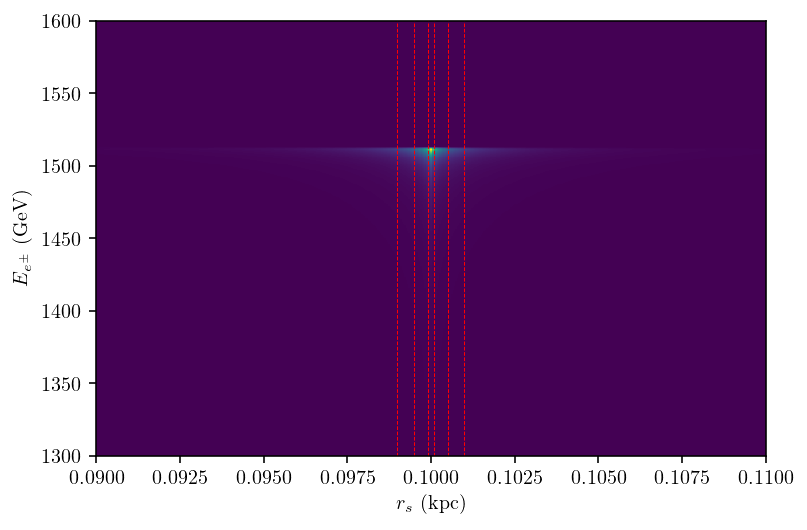

In [42]:
d = 0.1

# rs = np.logspace(np.log10(0.9*d), np.log10(1.1*d), 500)
# es = np.logspace(1, 3, 500)
# plt.xscale("log")
# plt.yscale("log")

rs = np.linspace(0.9*d, 1.1*d, 500)
es = np.linspace(1300, 1600, 500)

plt.pcolormesh(rs, es,
               np.vectorize(dphi2_de_dr)(*np.meshgrid(rs, es), d=d, rs=0.01,
                                         rhos=500., gamma=1., mx=mx, sv=sv, fx=1))

plt.axvline(0.99*d, linestyle='--', color='r', linewidth=0.5)
plt.axvline(0.995*d, linestyle='--', color='r', linewidth=0.5)
plt.axvline(0.999*d, linestyle='--', color='r', linewidth=0.5)
plt.axvline(1.001*d, linestyle='--', color='r', linewidth=0.5)
plt.axvline(1.005*d, linestyle='--', color='r', linewidth=0.5)
plt.axvline(1.01*d, linestyle='--', color='r', linewidth=0.5)

plt.xlabel(r"$r_s$ (kpc)")
plt.ylabel(r"$E_{e^\pm}$ (GeV)")

In [50]:
dist = 1.
r_s = 1e-3
rho_s = 5000.
gamma = 1.
halo = "nfw"

es = np.logspace(1, np.log10(mx), 300)

In [51]:
def dphi_de_e(e, dist, r_s, rho_s, gamma, halo, mx=dampe_excess_bin_high, sv=3e-26, fx=1.):
    if halo == "nfw":
        dphi2_de_dr = dphi2_de_dr_nfw_llc

    def _dphi_de_e(e, dist, r_s, rho_s, gamma):
        if e > mx:
            return 0.
        else:  # perform integration over r
            args = (e, dist, r_s, rho_s, gamma, mx, sv, fx)
            # Split integral around center of clump
            int_near, err_near = quad(dphi2_de_dr, 0, dist, args, points=[dist],
                                      epsabs=0, epsrel=1e-5)
            int_far, err_far = quad(dphi2_de_dr, dist, 10.*dist, args, points=[dist],
                                    epsabs=0, epsrel=1e-5)
            return int_near + int_far

    return np.vectorize(_dphi_de_e)(e, dist, r_s, rho_s, gamma)


def dphi_de_e_refined(e, dist, r_s, rho_s, gamma, halo, mx=dampe_excess_bin_high, sv=3e-26, fx=1.):
    if halo == "nfw":
        dphi2_de_dr = dphi2_de_dr_nfw_llc

    def _dphi_de_e(e, dist, r_s, rho_s, gamma):
        if e > mx:
            return 0.
        else:  # perform integration over r
            args = (e, dist, r_s, rho_s, gamma, mx, sv, fx)
            # Split integral around center of clump
            int_near, err_near = quad(dphi2_de_dr, 0, dist, args,
                                      points=[0.99*dist, 0.995*dist, 0.999*dist, dist],
                                      epsabs=0, epsrel=1e-5)
            int_far, err_far = quad(dphi2_de_dr, dist, 10.*dist, args,
                                    points=[dist, 1.001*dist, 1.005*dist, 1.01*dist],
                                    epsabs=0, epsrel=1e-5)
            return int_near + int_far

    return np.vectorize(_dphi_de_e)(e, dist, r_s, rho_s, gamma)

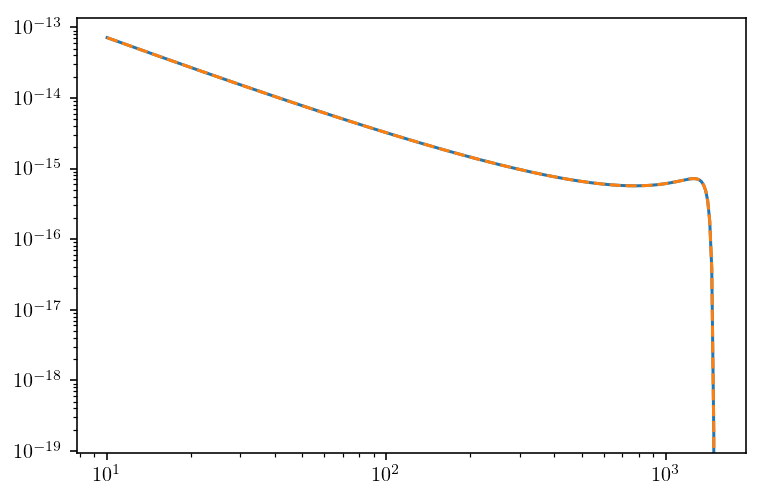

In [52]:
plt.loglog(es, dphi_de_e(es, dist, r_s, rho_s, gamma, halo))
plt.loglog(es, dphi_de_e_refined(es, dist, r_s, rho_s, gamma, halo), '--')

The $K$-factor can be noisy at distances past the clump

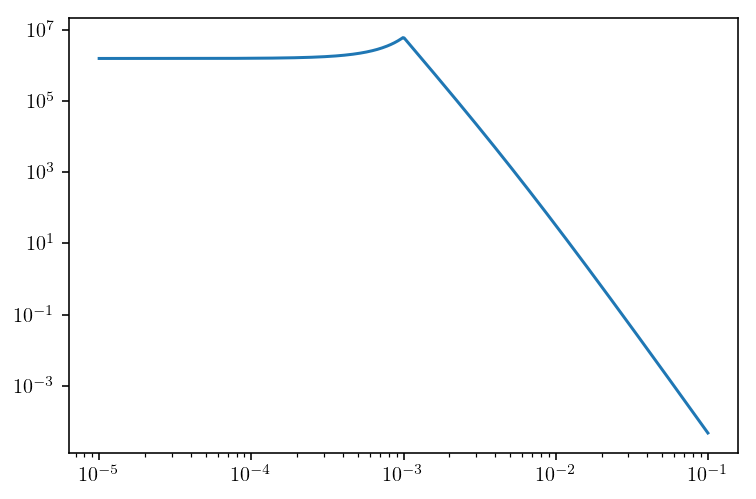

In [50]:
from nfw_clump import K_full

rs = np.logspace(np.log10(1e-2*dist), np.log10(1e2*dist), 500)

plt.loglog(rs, K_full(rs, dist, r_s, rho_s, gamma))

## Checking $J$-factor

It's numerically stable for NFW

The second function in this cell adds some extra trouble points. It agrees with my current results.

Weirdly, adding too many can cause `quad` to return infinity...

In [34]:
def J_factor(dist, r_s, rho_s, gamma, halo, th_max):
    """Computes J factor for a target region.

    Parameters
    ----------
    th_max : float
        Angular radius of the target.
    d : float
        Distance to center of DM clump in kpc.
    halo_params : namedtuple

    Returns
    -------
    J : float
        J factor in GeV^2/cm^5
    """
    if halo == "nfw":
        dJ_dr = dJ_dr_nfw_llc
    elif halo == "exp":
        dJ_dr = dJ_dr_tt

    def _J_factor(dist, r_s, rho_s, gamma):
        args = (th_max, dist, r_s, rho_s, gamma)
        # Split integral around center of clump
        int_near, err_near = quad(dJ_dr, 0., dist, args, points=[dist], epsabs=0, epsrel=1e-5)
        int_far, err_far = quad(dJ_dr, dist, 10.*dist, args, points=[dist], epsabs=0, epsrel=1e-5)
        return (int_near + int_far) * kpc_to_cm

    return np.vectorize(_J_factor)(dist, r_s, rho_s, gamma)

def J_factor_refined(dist, r_s, rho_s, gamma, halo, th_max):
    """Computes J factor for a target region.

    Parameters
    ----------
    th_max : float
        Angular radius of the target.
    d : float
        Distance to center of DM clump in kpc.
    halo_params : namedtuple

    Returns
    -------
    J : float
        J factor in GeV^2/cm^5
    """
    if halo == "nfw":
        dJ_dr = dJ_dr_nfw_llc
    elif halo == "exp":
        dJ_dr = dJ_dr_tt

    def _J_factor(dist, r_s, rho_s, gamma):
        args = (th_max, dist, r_s, rho_s, gamma)
        # Split integral around center of clump
        int_near, err_near = quad(dJ_dr, 0., dist, args,
                                  points=[0.99*dist, dist],
                                  epsabs=0, epsrel=1e-5)
        print(int_near, err_near)
        int_far, err_far = quad(dJ_dr, dist, 5.*dist, args,
                                points=[dist, 1.01*dist],
                                epsabs=0, epsrel=1e-5)
        print(int_far, err_far)
        return (int_near + int_far) * kpc_to_cm

    return np.vectorize(_J_factor)(dist, r_s, rho_s, gamma)

In [45]:
dist = 1e-3
r_s = 1e-3
rho_s = 5000.
gamma = 0.5
halo = "nfw"

In [65]:
print("Standard")
print(J_factor(dist, r_s, rho_s, gamma, halo, fermi_psf))
print("\nRefined")
print(J_factor_refined(dist, r_s, rho_s, gamma, halo, fermi_psf))

Standard
1.6198084512271467e+28

Refined
(2625612.9929465423, 23.995762541424483)
(2623279.0436195643, 3.677073805127293)
(2625612.9929465423, 23.995762541424483)
(2623279.0436195643, 3.677073805127293)
1.6198080824843005e+28


The integrand is very noisy away from the peak. Luckily the contribution from this region is negligible.

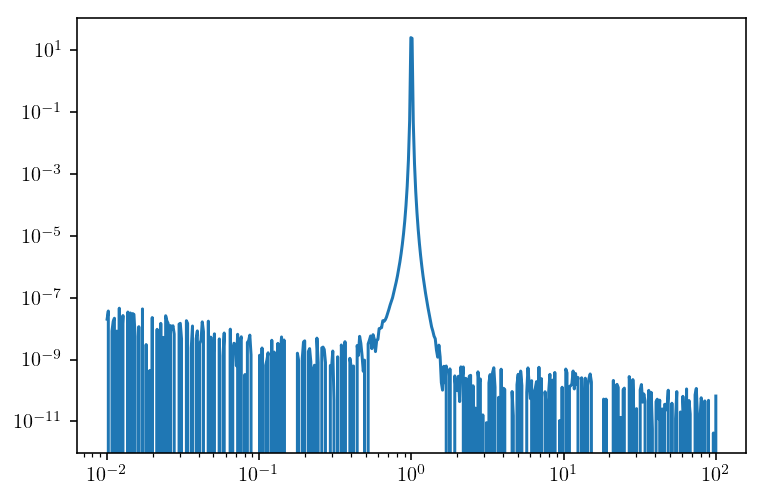

In [10]:
rs = np.logspace(np.log10(1e-2*dist), np.log10(1e2*dist), 500)

plt.loglog(rs, dJ_dr(rs, fermi_psf, dist, r_s, rho_s, gamma))

## Clump normalization

Using `nquad` to added the `points` argument makes the integration converge at the extreme corners of the $(d, r_s)$ plane

In [177]:
def rho_s_dampe_refined(dist, r_s, gamma, halo, bg_flux=bg_dampe, sv=3e-26, fx=1.):
    """Get density normalization giving best fit to excess.

    Parameters
    ----------
    d : float
        Distance to the clump's center, kpc.
    bg_flux : float -> float
        Background flux in (GeV cm^2 s sr)^-1
    sv : float
        DM self-annihilation cross section, cm^3/s.

    Returns
    -------
    rho_s : float
        Density normalization in GeV / cm^3.
    """
    mx = dampe_excess_bin_high

    # Residual integrated flux
    @cfunc(float64(float64))
    def bg_flux_cf(e):
        return bg_flux(e)
    bg_flux_LLC = LowLevelCallable(bg_flux_cf.ctypes)
    bg_iflux = quad(bg_flux_LLC, dampe_excess_bin_low, dampe_excess_bin_high,
                    epsabs=0, epsrel=1e-5)[0]
    residual_iflux = dampe_excess_iflux - bg_iflux

    if halo == "nfw":
        dphi2_de_dr = dphi2_de_dr_nfw_llc
    elif halo == "exp":
        dphi2_de_dr = dphi2_de_dr_tt

    def _rho_s_dampe(dist, r_s, gamma):
        # Set rho_s to 1 and use the fact that the flux is proportional to
        # rho_s**2
        args = (dist, r_s, 1., gamma, mx, sv, fx)
        # Improve numerical stability by splitting the spatial integral. The
        # factor of 2 accounts for DAMPE measuring e+ and e-.
        points_fact_below = np.array([0.99, 0.995, 0.999, 0.9999])
        points_fact_above = np.array([1.0001, 1.001, 1.005, 1.01])
        
        dm_iflux_near, err_near = nquad(
            dphi2_de_dr, args=args,
            ranges=[(0, dist), (dampe_excess_bin_low, dampe_excess_bin_high)],
            opts=[{"epsabs": 0, "epsrel": 1e-5, "points": points_fact_below*dist},
                  {"epsabs": 0, "epsrel": 1e-5, "points": points_fact_below*dampe_excess_bin_high}])

        dm_iflux_far, err_far = nquad(
            dphi2_de_dr, args=args,
            ranges=[(dist, 10*dist), (dampe_excess_bin_low, dampe_excess_bin_high)],
            opts=[{"epsabs": 0, "epsrel": 1e-5, "points": points_fact_above*dist},
                  {"epsabs": 0, "epsrel": 1e-5, "points": points_fact_below*dampe_excess_bin_high}])

        return np.sqrt(residual_iflux / (2 * (dm_iflux_near + dm_iflux_far)))

    return np.vectorize(_rho_s_dampe)(dist, r_s, gamma)

In [180]:
dist = 1.e-3
r_s = 1e-3
gamma = 1.
halo = "nfw"

In [181]:
print("Standard")
print(rho_s_dampe(dist, r_s, gamma, halo))

print("\nRefined")
print(rho_s_dampe_refined(dist, r_s, gamma, halo))

Standard
nan

Refined
2518.028111104646


## Anisotropy

In [2]:
# from nfw_clump import aniso_numerator_de_dr_dd_llc as aniso_numerator_de_dr_dd_nfw_llc
from nfw_clump import aniso_numerator_de_dr_dd
from finite_clump_vectorized import dphi_de_e

In [26]:
def integrated_aniso_refined(dist, r_s, rho_s, gamma, halo, e_low=e_low_aniso_fermi[-1],
                             e_high=e_high_aniso_fermi[-1], bg_flux=bg_dampe,
                             mx=dampe_excess_bin_high, sv=3e-26, fx=1.):
    """Computes delta(e), the differential e- anisotropy.
    """
    # if halo == "exp":
    #     dphi3_de_dr_dd = dphi3_de_dr_dd_exp
    if halo == "nfw":
        aniso_numerator_de_dr_dd_llc = aniso_numerator_de_dr_dd
#         aniso_numerator_de_dr_dd_llc = aniso_numerator_de_dr_dd_nfw_llc

    def _helper(dist, r_s, rho_s):
        args = (dist, r_s, rho_s, gamma, mx, sv, fx)
        points_fact_below = np.array([0.99, 0.999, 0.9999, 0.99999, 0.999999])
        points_fact_above = np.array([1.000001, 1.00001, 1.0001, 1.001, 1.01])

        numerator_near, err_near = nquad(
            aniso_numerator_de_dr_dd_llc, args=args,
            ranges=[(0, dist), (dampe_excess_bin_low, dampe_excess_bin_high)],
            opts=[{"epsabs": 0, "epsrel": 1e-5, "points": points_fact_below*dist},
                  {"epsabs": 0, "epsrel": 1e-5, "points": points_fact_below*dampe_excess_bin_high}])

        numerator_far, err_far = nquad(
            aniso_numerator_de_dr_dd_llc, args=args,
            ranges=[(dist, 10*dist), (dampe_excess_bin_low, dampe_excess_bin_high)],
            opts=[{"epsabs": 0, "epsrel": 1e-5, "points": points_fact_above*dist},
                  {"epsabs": 0, "epsrel": 1e-5, "points": points_fact_below*dampe_excess_bin_high}])

        denom = quad(dphi_de_e, e_low, e_high,
                     args=(dist, r_s, rho_s, gamma, halo, mx, sv, fx),
                     epsabs=0, epsrel=1e-5)[0]

        @jit(nopython=True)
        def _int_bg(e):
            return bg_flux(e)

        denom += quad(_int_bg, e_low, e_high, epsabs=0, epsrel=1e-5)[0]

        return (numerator_near + numerator_far) / denom

    return np.vectorize(_helper)(dist, r_s, rho_s)

In [41]:
dist = 1e-1  # kpc
r_s = 1e-3  # kpc
rho_s = 1.  # GeV/cm^3
gamma = 0.7
halo = "nfw"

e_low = e_low_aniso_fermi[-1]
e_high = e_high_aniso_fermi[-1]

Compute the anisotropy

In [42]:
dist_mg, r_s_mg = np.meshgrid(np.logspace(-3, 0, 5), np.logspace(-3, 1, 5))

anisos = integrated_aniso_refined(dist_mg, r_s_mg, rho_s, gamma, halo, e_low, e_high)

KeyboardInterrupt: 

In [ ]:
anisos.min(), anisos.max()

Scaling looks correct. With fixed density normalization, increasing $r_s$ skews the CREs' arrival directions even more toward the clump. Additionally, the anisotropy increases with $\gamma$.

<a list of 4 text.Text objects>

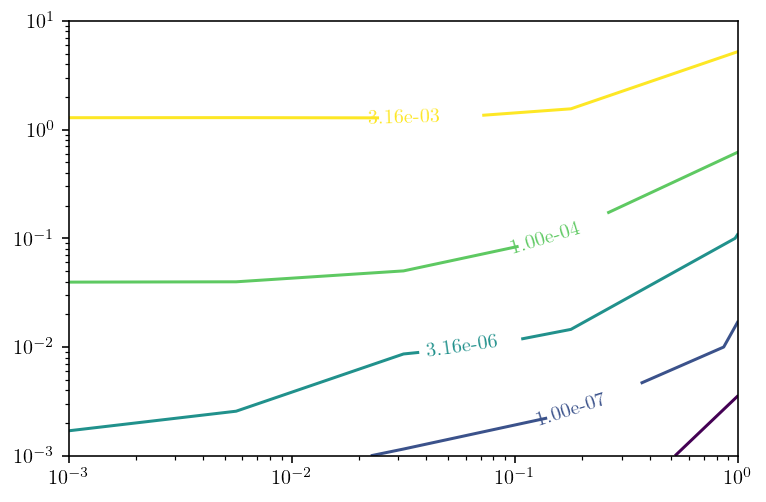

In [25]:
plt.xscale("log")
plt.yscale("log")
cs = plt.contour(dist_mg, r_s_mg, anisos, levels=np.logspace(-10, -1, 7), norm=LogNorm())
plt.clabel(cs, cs.levels, fmt="%.2e", inline=True, fontsize=10)

Study the integrand, which is very narrowly peaked.

/Users/acoogan/.pyenv/versions/2.7.13/lib/python2.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log10


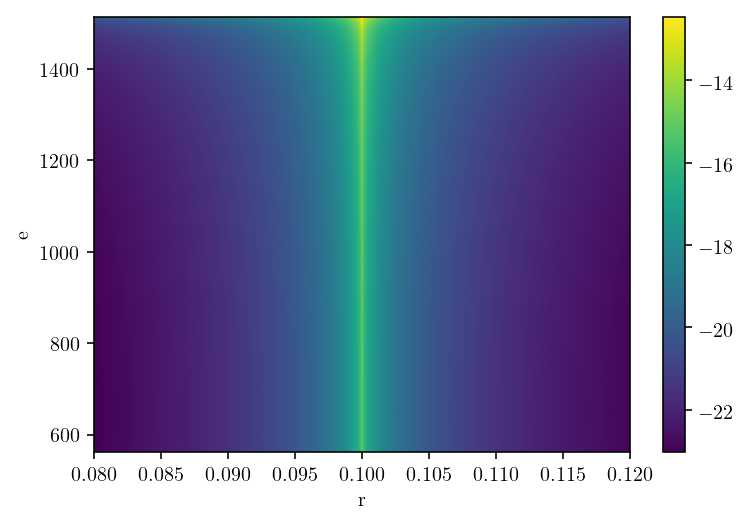

In [17]:
dist = 1e-1  # kpc
r_s = 1e-3  # kpc
rho_s = 1.  # GeV/cm^3
gamma = 0.9
halo = "nfw"

rs = np.linspace(0.8*dist, 1.2*dist, 500)
es = np.linspace(e_low_aniso_fermi[-1], np.min([mx, e_high_aniso_fermi[-1]]), 500)

# rs = np.logspace(np.log10(0.95*dist), np.log10(1.05*dist), 500)
# es = np.logspace(np.log10(e_low_aniso_fermi[-1]),
#                  np.log10(np.min([mx, e_high_aniso_fermi[-1]])),
#                  500)
# plt.xscale("log")
# plt.yscale("log")

plt.pcolormesh(rs, es,
               np.log10(np.vectorize(
                   lambda r, e: aniso_numerator_de_dr_dd(
                       r, e, dist, r_s, rho_s, gamma, mx, sv, fx))(*np.meshgrid(rs, es))))
plt.xlabel("r")
plt.ylabel("e")
plt.colorbar()

562.0611865686938
799.9458899265203
1037.8305932843468
1275.7152966421734
1513.6


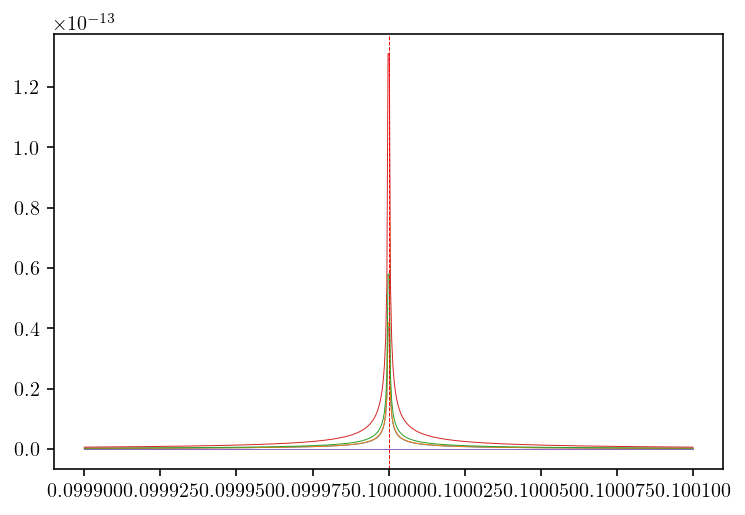

In [25]:
rs = np.linspace(0.999*dist, 1.001*dist, 500)
es = np.linspace(e_low_aniso_fermi[-1], np.min([mx, e_high_aniso_fermi[-1]]), 5)

for e in es:
    print(e)
    plt.plot(rs, [aniso_numerator_de_dr_dd(r, e, dist, r_s, rho_s, gamma, mx, sv, fx) for r in rs],
               linewidth=0.5)

plt.axvline(dist, linestyle='--', color='r', linewidth=0.5)
# plt.ylim(1e-16, 5e-8)